# # Homework 3

COMS W4995-Topics in Computer Science: Machine Learning with Applications in Finance

Instructor: Germán G. Creamer 

Minyue Liu ml4368

***

Use CARTC, Random Forests and Adaboost to forecast the customers that default their obligations and calculate their probability of default.

Split the data into training (75%) and test (25%) dataset. Using cross-validation with 10 folds of the training dataset, calibrate the models selecting the optimal values for at least one parameter of each model. Report the optimal parameters selected.

Transform the categorical variables into dummy variables. A dummy variable is a binary variable taking the value of one for a particular value of a categorical variable, and the rest is zero. If the categorical variable has k classes, it is necessary to generate k-1 dummy variables as one class is determined when all the other dummy variables are zero.

Standardize the dataset:  rescale the data as if each feature is normally distributed (Gaussian with zero mean and unit variance)

Compare the Matthews Correlation Coefficient, the test error, and the average probability of default for the test sample using the three models.

Rank the features’  importance using Random Forest.

Select the best model and create a histogram with 10 bins for the probability of default.

Calculate credit score for each customer using the following formula:

p =probability of default   
odds = (1 - p) / p
scores = log(odds)*(40/log(2)) + 340
where log is natural log.

 

Create a histogram with 10 bins for the credit scores.

Discuss your results explaining the performance measure obtained and the average of the probability of default.

Note: Matthews correlation coefficient measures the quality of binary and multiclass classifications. It can be used even if the classes are of very different sizes. This is a correlation coefficient value between -1 (perfect prediction), 0 (average random prediction) and -1 (inverse prediction). 

In [104]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold


import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

In [59]:
# Load data
path = "./default1.csv"
df = pd.read_csv(path)[["ID","creditBalance","Gender","Training","MaritalStatus","Age","payStatus6","payStatus5","payStatus4","payStatus3","payStatus2","payStatus1","bill6","bill5","bill4","bill3","bill2","bill1","payment6","payment5","payment4","payment3","payment2","payment1","Default"]].dropna()
# Take a look at the data
df.head(5)

,ID,creditBalance,Gender,Training,MaritalStatus,Age,payStatus6,payStatus5,payStatus4,payStatus3,...,bill3,bill2,bill1,payment6,payment5,payment4,payment3,payment2,payment1,Default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [60]:
df.shape

(30000, 25)

In [61]:
##Transform the categorical variables into dummy variables.
for field in ['Gender','Training','MaritalStatus']:
    dummies = pd.get_dummies(df[field])
#     print(dummies)
#     print(dummies.columns)
    if field == "Gender":
        dummies.columns = ['Gender_male','Gender_female']
        data = pd.concat([df, dummies], axis=1).drop(field, axis="columns")
        
    elif field == "Training":
#         print(dummies)
        dummies.columns = ['Training_0','Training_graduate school','Training_university','Training_high school','Training_4','Training_5','Training_6']
        data = pd.concat([data, dummies], axis=1).drop(field, axis="columns")
    
    else:
        dummies.columns = ['Marital_0','Marital_married','Marital_single','Marital_3']
        data = pd.concat([data, dummies], axis=1).drop(field, axis="columns")

# data = data.drop('Marital_0',axis = "columns")
# data = data.drop('Marital_3',axis = "columns")
# data = data.drop('Gender_male',axis = "columns")
# data = data.drop('Training_4',axis = "columns")
# data = data.drop('Training_5',axis = "columns")
# data = data.drop('Training_6',axis = "columns")
data.head()



,ID,creditBalance,Age,payStatus6,payStatus5,payStatus4,payStatus3,payStatus2,payStatus1,bill6,...,Training_graduate school,Training_university,Training_high school,Training_4,Training_5,Training_6,Marital_0,Marital_married,Marital_single,Marital_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,0,1,0,0,0,0,0,1,0,0
1,2,120000,26,-1,2,0,0,0,2,2682,...,0,1,0,0,0,0,0,0,1,0
2,3,90000,34,0,0,0,0,0,0,29239,...,0,1,0,0,0,0,0,0,1,0
3,4,50000,37,0,0,0,0,0,0,46990,...,0,1,0,0,0,0,0,1,0,0
4,5,50000,57,-1,0,-1,0,0,0,8617,...,0,1,0,0,0,0,0,1,0,0


In [62]:
##Standardize the dataset:  rescale the data as if each feature is normally distributed (Gaussian with zero mean and unit variance)
# data_scaled.head()
# predict_col = ["creditBalance","Training","Age","payStatus6","payStatus5","payStatus4","payStatus3","payStatus2","payStatus1","bill6","bill5","bill4","bill3","bill2","bill1","payment6","payment5","payment4","payment3","payment2","payment1","Gender_female","Marital_married","Marital_single"]
data_ID = data["ID"]
data_Default = data["Default"]
data = data.drop("ID",axis = "columns")
data = data.drop("Default",axis = "columns")
data.head()
# print(data_ID)
# print(data_Default)

data_scaled = pd.DataFrame(scale(data, axis=0, with_mean=True, with_std=True, copy=True), columns=data.columns.values)
data_scaled["ID"] = data_ID
data_scaled["Default"] = data_Default  
data_scaled.head()

,creditBalance,Age,payStatus6,payStatus5,payStatus4,payStatus3,payStatus2,payStatus1,bill6,bill5,...,Training_high school,Training_4,Training_5,Training_6,Marital_0,Marital_married,Marital_single,Marital_3,ID,Default
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1,1
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,2,1
2,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,3,0
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,4,0
4,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,...,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,5,0


In [63]:
##Split the data into training (75%) and test (25%) dataset. 
##Using cross-validation with 10 folds of the training dataset
##calibrate the models selecting the optimal values for at least one parameter of each model. 
##Report the optimal parameters selected.

##split dataset
rs = np.random.RandomState(11435)
is_test = rs.uniform(0, 1, len(data_scaled)) > 0.75
train = data_scaled[is_test==False]
test = data_scaled[is_test==True]
X_train = train.drop(["ID","Default"],axis ="columns")
X_test = test.drop(["ID","Default"],axis ="columns")
Y_train = train["Default"]
Y_test = test["Default"]

In [64]:
len(X_train), len(Y_test)

(22432, 7568)

In [65]:
X_train

,creditBalance,Age,payStatus6,payStatus5,payStatus4,payStatus3,payStatus2,payStatus1,bill6,bill5,...,Training_graduate school,Training_university,Training_high school,Training_4,Training_5,Training_6,Marital_0,Marital_married,Marital_single,Marital_3
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
6,2.562830,-0.703588,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,4.301531,5.098086,...,1.354326,-0.937295,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
7,-0.520128,-1.354506,0.014861,-0.723570,-0.696663,0.188746,0.234917,-0.616452,-0.534359,-0.685644,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,-0.520128,0.272789,0.014861,-0.723570,-0.696663,0.188746,0.234917,0.253137,-0.654330,-0.670934,...,1.354326,-0.937295,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
29994,-0.674276,-0.161156,1.794564,1.782348,1.809921,1.899436,1.999879,1.992316,0.289723,0.400842,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326
29995,0.404759,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.870379,2.018136,...,-0.738375,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326
29997,-1.059646,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,-0.647227,-0.643830,...,-0.738375,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326


In [66]:
Y_train

0        1
1        1
3        0
6        0
7        0
        ..
29993    0
29994    1
29995    0
29997    1
29998    1
Name: Default, Length: 22432, dtype: int64

In [67]:
kfold = StratifiedKFold(n_splits=10, shuffle = True,random_state= 1)

In [68]:
## CART

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


 
model_dt = DecisionTreeClassifier()
 
max_depth = range(1,10,1)
# min_samples_leaf = range(1,10,2)
criteria = ['entropy','gini']
grid = dict(max_depth=max_depth,criterion = criteria)
# print(tuned_parameters)
# print(min_samples_leaf)

tuned_model_dt = GridSearchCV(model_dt, grid, scoring="accuracy", cv=kfold, verbose=1)
tuned_model_dt.fit(X_train, Y_train)

 

print ("Best accuracy: %0.4f, using: " % tuned_model_dt.best_score_)
print (tuned_model_dt.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best accuracy: 0.8233, using: 
{'criterion': 'gini', 'max_depth': 2}


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   20.1s finished


In [69]:
print(tuned_model_dt.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [70]:
## Random Forests 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


 
model_rf = RandomForestClassifier()
n_estimators = [3,30,50]
# max_features = [2, 4, 6, 8]
max_depth = range(1,20,5)
criteria = ['entropy','gini']
grid = dict(n_estimators = n_estimators, max_depth = max_depth,criterion = criteria)

tuned_model_rf = GridSearchCV(model_rf, grid, scoring="accuracy", cv=kfold, verbose=1)
tuned_model_rf.fit(X_train, Y_train)

 

print ("Best accuracy: %0.4f, using: " % tuned_model_rf.best_score_)
print (tuned_model_rf.best_params_)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.0min finished


Best accuracy: 0.8209, using: 
{'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 50}


In [71]:
print(tuned_model_rf.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [72]:
## Adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


 
model_ad = AdaBoostClassifier()
n_estimators = [10,30,50]
# max_features = [2, 4, 6, 8]
learning_rate = [0.001,0.01,0.1,0.3,0.5,0.8,1]
grid = dict(n_estimators = n_estimators, learning_rate = learning_rate)

tuned_model_ad = GridSearchCV(model_ad, grid, scoring="accuracy", cv=kfold, verbose=1)
tuned_model_ad.fit(X_train, Y_train)


print ("Best accuracy: %0.4f, using: " % tuned_model_ad.best_score_)
print (tuned_model_ad.best_params_)





Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  2.4min finished


Best accuracy: 0.8227, using: 
{'learning_rate': 0.001, 'n_estimators': 10}


In [73]:
print(tuned_model_ad.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.001, n_estimators=10, random_state=None)


In [78]:
###compare test error rate
acc_dt = metrics.accuracy_score(tuned_model_dt.predict(X_test), Y_test)
# print(acc_dt)
err_dt  = 1-acc_dt
print ("test error rate of dt: %0.4f: " % err_dt)
acc_rf = metrics.accuracy_score(tuned_model_rf.predict(X_test), Y_test)
err_rf  = 1-acc_rf
print ("test error rate of rf: %0.4f: " % err_rf)
acc_ad = metrics.accuracy_score(tuned_model_ad.predict(X_test), Y_test)
err_ad  = 1-acc_ad
print ("test error rate of ad: %0.4f: " % err_ad)
# tuned_model_dt.predict_proba(X)

test error rate of dt: 0.1901: 
test error rate of rf: 0.1872: 
test error rate of ad: 0.1896: 


In [79]:
###compare matthews_corrcoef
from sklearn.metrics import matthews_corrcoef

mcc_dt = matthews_corrcoef(Y_test, tuned_model_dt.predict(X_test))
mcc_rf = matthews_corrcoef(Y_test, tuned_model_rf.predict(X_test))
mcc_ad = matthews_corrcoef(Y_test, tuned_model_ad.predict(X_test))
print("Matthews Correlation Coefficient for dt: %0.4f " % mcc_dt)
print("Matthews Correlation Coefficient for rf: %0.4f" % mcc_rf)
print("Matthews Correlation Coefficient for ad: %0.4f" % mcc_ad)

Matthews Correlation Coefficient for dt: 0.3477 
Matthews Correlation Coefficient for rf: 0.3698
Matthews Correlation Coefficient for ad: 0.3527


In [80]:
###the average probability of default
avg_prob_dt = tuned_model_dt.predict_proba(X_test)[:,1].mean()
avg_prob_rf = tuned_model_rf.predict_proba(X_test)[:,1].mean()
avg_prob_ad = tuned_model_ad.predict_proba(X_test)[:,1].mean()
print("average probability of default using dt: %0.4f" % (avg_prob_dt*100))
print("average probability of default using rf: %0.4f" % (avg_prob_rf*100))
print("average probability of default using ad: %0.4f" % (avg_prob_ad*100))




average probability of default using dt: 21.7652
average probability of default using rf: 21.8087
average probability of default using ad: 21.6748


In [81]:
##comparison table
cols = ["test error rate", "Matthews Correlation Coefficient","average probability of default"]
res = [[err_dt,mcc_dt,(avg_prob_dt*100)],[err_rf,mcc_rf,(avg_prob_rf*100)],[err_ad,mcc_ad,(avg_prob_ad*100)]]
index = ["dt","rf","ad"]
ans = pd.DataFrame(res,index,cols)
ans.head()

,test error rate,Matthews Correlation Coefficient,average probability of default
dt,0.190143,0.347714,21.765193
rf,0.187236,0.369781,21.808734
ad,0.189614,0.352702,21.674819


After run the gridsearch and cross validation, I found that as for decision tree, the model with gini criterion and max_depth 2 has the best accuracy 0.8233. As for the random forest, the model with entropy criterion, max_depth 11 and 50 estimatiors has the best accuracy: 0.8209. As for the adaboost, the model with learning_rate 0.001 and 10 estimators has the best accuracy 0.8227.

According to the result, based on test error rate metric, we can see that the random forest performed the best among the three with the test error rate 0.187236 while the decision tree is the worst with the rate of 0.190143.

According to matthews correlation coefficient which is more suitbale here since the dataset is unbalanced with 22% of "1"s, the random forest is the best with the coefficient 0.369781 while decision tree is the worst with the value of 0.347714. The best model selected by the matthews correlation coefficient is the same as the one selected by test error rate. 

The average probability of default are very similary among the 3 models which is around 22%. In general, these three models performed similarly over this dataset.

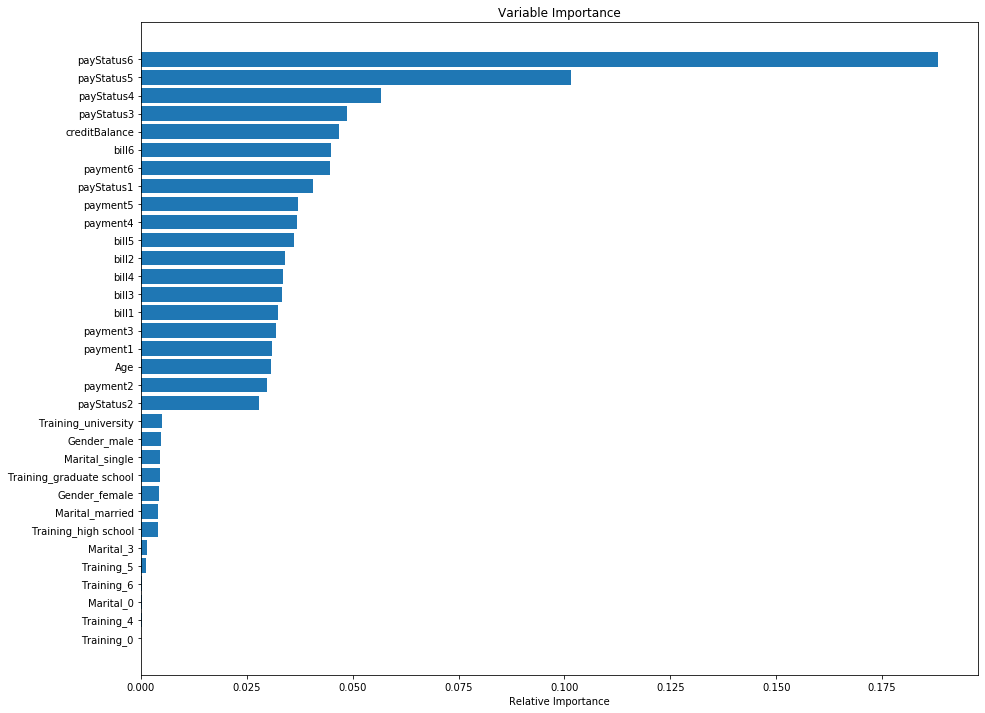

In [82]:
###Rank the features’ importance using Random Forest.
import pylab as pl

importances = tuned_model_rf.best_estimator_.feature_importances_
sorted_idx = np.argsort(importances)
features = X_train.columns
features_num = len(X_train.columns)
# print(features)
padding = np.arange(features_num) + 0.5
pl.barh(padding, importances[sorted_idx], align='center')
pl.yticks(padding, features[sorted_idx])
pl.xlabel("Relative Importance")
pl.title("Variable Importance")
pl.show()

We can see that the payStatus6 and payStatus 5 are the most important features according to the diagram since the relative importance are very high. While the Gender, MaritalStatus and Training are not that important compared to the payStatus, creditbalance and bill. 

In [83]:
###Select the best model and create a histogram with 10 bins for the probability of default.

prob_best = tuned_model_rf.predict_proba(X_test)[:,1]
# print(len(prob_rf))
# print(type(prob_rf))
prob_best_bin = pd.cut(prob_best, bins=10)
prob_best_bin_count = pd.value_counts(prob_best_bin)
prob_best_bin_count


(0.114, 0.209]     2863
(0.0182, 0.114]    2381
(0.209, 0.304]      779
(0.304, 0.399]      426
(0.494, 0.589]      298
(0.399, 0.494]      267
(0.589, 0.684]      240
(0.684, 0.779]      211
(0.779, 0.874]       87
(0.874, 0.969]       16
dtype: int64

(array([2381., 2863.,  779.,  426.,  267.,  298.,  240.,  211.,   87.,
          16.]),
 array([0.01914374, 0.1140852 , 0.20902665, 0.30396811, 0.39890957,
        0.49385102, 0.58879248, 0.68373394, 0.77867539, 0.87361685,
        0.9685583 ]),
 <a list of 10 Patch objects>)

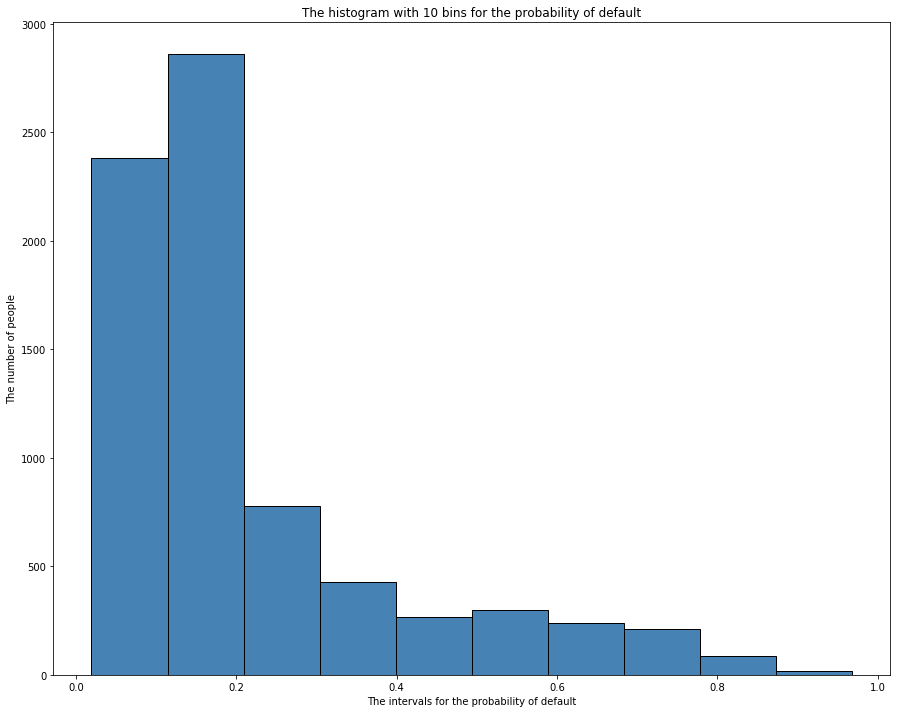

In [84]:
plt.title("The histogram with 10 bins for the probability of default")
plt.xlabel("The intervals for the probability of default")
plt.ylabel("The number of people")
plt.hist(x=prob_best,bins=10,
        color="steelblue",
        edgecolor="black")

From the Histogram, we know that in the test set, most of the people (around 2500) with the number of 2381 and 2863 have the probability of default 2% to 21%. Few people with the number of 16 have the highest probability of default which is around 87% to 96%.

In [95]:
###Calculate credit score for each customer using the following formula:
def credit_score(p):
    odds = (1 - p) / p
    scores = np.log(odds)*(40/np.log(2)) + 340
    return scores.astype(np.int)


In [96]:
###Create a histogram with 10 bins for the credit scores.
from collections import Counter

scores =credit_score(prob_best)
# s = pd.DataFrame(data = scores,columns = ["creditscore"])


(array([   8.,    7.,  103.,  343.,  553.,  764., 1994., 2828.,  889.,
          79.]),
 array([142. , 184.5, 227. , 269.5, 312. , 354.5, 397. , 439.5, 482. ,
        524.5, 567. ]),
 <a list of 10 Patch objects>)

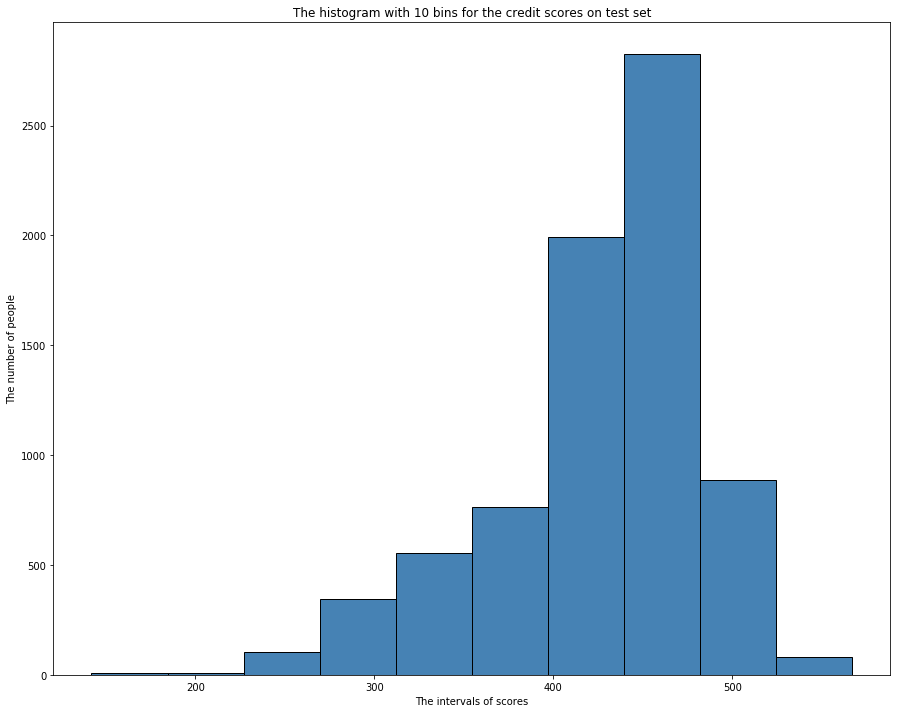

In [107]:
plt.title("The histogram with 10 bins for the credit scores on test set")
plt.xlabel("The intervals of scores")
plt.ylabel("The number of people")
pl.hist(x=scores,bins=10,
        color="steelblue",
        edgecolor="black")


We know that most people (around 2000 or above 2500 people) in the test set have the credit score between 400 to 500. Few people have the lowest score which is between 100 to 200. And there are some people (under 100 people) have the highest score which is above 500.

(array([   34.,    46.,   286.,  1364.,  1944.,  2759.,  7145., 12391.,
         3748.,   283.]),
 array([116. , 161.8, 207.6, 253.4, 299.2, 345. , 390.8, 436.6, 482.4,
        528.2, 574. ]),
 <a list of 10 Patch objects>)

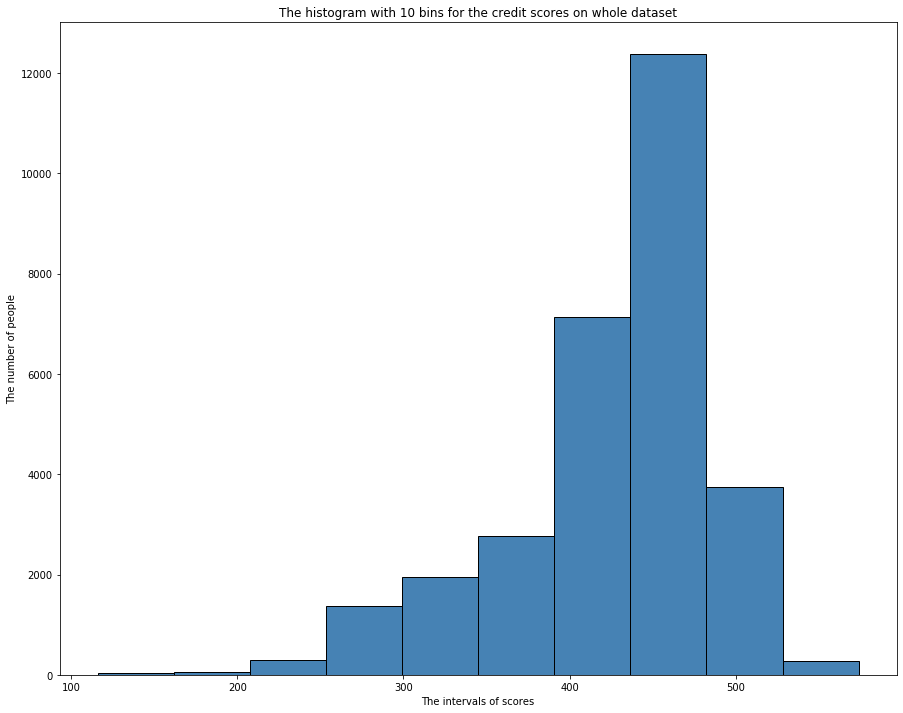

In [88]:
whole_data = data_scaled.drop(["ID","Default"],axis = "columns")
# print(len(whole_data))
# whole_data

prob_whole_dataset = tuned_model_rf.predict_proba(whole_data)[:,1]
whole_scores =credit_score(prob_whole_dataset)

plt.title("The histogram with 10 bins for the credit scores on whole dataset")
plt.xlabel("The intervals of scores")
plt.ylabel("The number of people")
pl.hist(x=whole_scores,bins=10,
        color="steelblue",
        edgecolor="black")

On the whole test set, the distribution follows the same way as it did on the test set. We know that most people (around 12000 people) in the whole dataset have the credit score around 450. Few people (below 100 people) have the lowest score which is between 100 to 200. 